# HR-аналитика

<a id='content'></a>

<div> 

**Заказчик:** отдела HR-аналитики компании «Работа с заботой»

**Цель:** Создать инструмент для прогнозирования удовлетворенности сотрудников и вероятности их ухода из компании «Работа с заботой».

**Исходные данные** Для решения поставленной задачи используются данные предоставленные компанией с характеристиками сотрудников компании. 

Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

На основе этих данных будет построены две модели:
1. *Первая* предскажет уровень удовлетворенности сотрудника. Обучение с учителем, задача регрессии.
2. *Вторая* модель будет предсказывать собирается ли сотрудник уволиться из компании. Обучение с учителем, задача классификации.

**Ход исследования**:

* <a href='#know_the_data'>Знакомство с данными</a> </br>
* <a href='#data_preprocessing'>Предобработка данных</a> </br>
* <a href='#data_analysis'>Исследовательский анализ данных</a></br>
* <a href='#Correlation_analysis'>Корреляционный анализ</a></br> 
* <a href='#ML'>Обучение моделей с помощью пайплайнов</a></br>

    *<a href='#regression'>Модель для предсказания удовлетворенности сотрудников (модель регрессии)</a> </br>
    
    *<a href='#classification'>Модель для предсказания увольнения сотрудника (модель классификации)</a> </br> 
    
* <a href='#conclusions'>Выводы</a></br> 

</div>



## Знакомство с данными

In [1]:
!pip install pandas==2.2.2 seaborn==0.13.2 numba==0.60.0 numpy==1.26.4 -q

In [2]:
!pip install imbalanced-learn==0.12.4 shap==0.46.0  -q

In [3]:
!pip install phik==0.12.4 matplotlib==3.9.0 -q

In [4]:
#Загрузим библиотеки
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import phik
import warnings
import sklearn
import shap
import math

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (8,6)

<div> 

*Функции, используемые в работе*

</div>

In [5]:
# Функция для построения гистограмм
def plot_histograms(df, columns, rows=2):
    """
    Строит гистограммы для указанных числовых столбцов в DataFrame.

    Args:
        df: DataFrame с данными.
        columns: Список названий числовых столбцов.
        rows: Количество рядов в сетке графиков.
    """
    num_plots = len(columns)
    cols = num_plots // rows + (num_plots % rows > 0)  
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols*5, rows*4))
    axes = axes.flatten()  # Преобразуем массив осей в одномерный список

    for i, col in enumerate(columns):
        sns.histplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_ylabel('Количество')

    plt.tight_layout()
    plt.show()


#Функция для загрузки дата сета

def loading_data(file_name, 
                 df_name, sep=',', 
                 graf=True, 
                 missingno=False, 
                 figsize=(15,10), 
                 bins=30):
    
    try:
        df = pd.read_csv('assets/'+  file_name, sep=sep, decimal=".") 
    except:
        df = pd.read_csv('/datasets/' + file_name, sep=sep, decimal=".") 
    
    pd.set_option("display.max_columns", None)
    
    print(df_name)
    display(df.head(5))
    print('-'*80)
    print('Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти ')
    print()
    print(df.info())
    print('-'*80)
    print('Оценим количество пропущенных значений в каждом столбце')
    print()
    display(df.isna().sum())
    
    if missingno == True:
        print('-'*80)
        print('Визуализируем пропуски в данных')
        msno.matrix(df, figsize = (10,8))
    if graf == True:
        plt.show()
        print('-'*80)
        print('Визуализируем общие данные')
        if 'id' in df.columns:
            df_new = df.drop(columns=['id'])
        else:
            df_new = df

        # Вызываем функцию, указав желаемое количество рядов
        numeric_cols = df_new.select_dtypes(include=['number']).columns
        rows = math.ceil(len(numeric_cols)/3)
        
        if len(numeric_cols) == 1:
            df_new[numeric_cols].hist()
        else:
            plot_histograms(df_new, numeric_cols, rows=rows)
        plt.show()
     
    return df

In [6]:
#Предобработка, удаление явных дубликатов
def remove_duplicates(data, title):
    num_duplicates = data.duplicated().sum()
    if num_duplicates != 0:
        print('Количество явных дубликатов в ', title, ':', data.duplicated().sum())
        print('Размер', title, 'до удаления дубликатов:', data.shape)
        data = data.drop_duplicates(keep = 'first')
        print('Размер', title, 'после удаления дубликатов:', data.shape)
        return data
    else:
        print('Явные дубликаты в', title, 'отсутсвуют')
        return data

In [7]:
'''
  Находит уникальные значения в указанных столбцах нескольких датафреймов.

  Args:
    dataframes: Список датафреймов.
    columns: Словарь, где ключи - имена датафреймов, а значения - списки столбцов.

  Returns:
    None (выводит результаты на печать).
'''
def find_unique_values(dataframes, columns):
  for df_name, df in dataframes.items():
    for col in columns:
      unique_values = df[col].unique()
      print(f"Уникальные значения в столбце {col} датафрейма {df_name}:")
      print(unique_values)
      print()

In [8]:
'''
Исследовательский анализ данных
Гистограмма и ящик с усами
data - series
title - название для графика
'''
def my_plot(data,x_column, hue_column, my_title, bins=50):
    sns.histplot(data, 
                 x=data[x_column],
                 hue=hue_column, bins=50, 
                 palette="Set1", 
                 linewidth=0.3, 
                 kde=True, 
                 legend=True,
                 stat='density', common_norm=False)
    sns.set_context(rc={'legend.fontsize': 24})
    label = 'Гистограмма распределения '+ my_title
    plt.title(label=label, fontsize = 24, y = 1, color = 'midnightblue')
    plt.grid(True)
    plt.rcParams['font.size'] = 20
    plt.ylabel('Плотность вероятности', fontsize = 20)
    plt.axvline(x=data[x_column].mean(), 
                color='black', 
                label='Среднее',
                linewidth = 2)
    plt.axvline(x=data[x_column].median(), 
                color='black', 
                linestyle='--', 
                label='Медиана',
                linewidth = 2)
    #plt.legend()
    
def my_boxplot(data, my_title):
    # постройте ящик с усами целевого признака с горизонтальной ориентацией
    label = 'График ящик с усами для ' + my_title
    plt.rcParams['font.size'] = 18
    plt.title(label, fontsize = 24, y = 1, color='midnightblue')
    plt.boxplot(data, vert=False)
    plt.grid(True)

In [9]:
#Круговая диаграмма
def my_pie (data, my_title):
    counts = []
    labels = []
    for i in data.unique():
        labels.append(i)
        count = data.loc[data == i].count()
        counts.append(count)
    
    plt.pie(counts, labels=labels, autopct='%1.2f%%')
    plt.rcParams['font.size'] = 20
    plt.legend(loc='best')
    plt.legend(loc='upper left', bbox_to_anchor=(1.1, 1.0))
    my_title = 'Соотношение ' + my_title
    plt.title(my_title, fontsize = 24, y = 1.0)
    

In [10]:
# Функция для расчета SMAPE в задачах регрессии
def smape_score(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)*2
    denominator = (y_true + y_pred)

    return  100 / n * np.sum(numerator / denominator)


satisfaction_train


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None
-------------

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


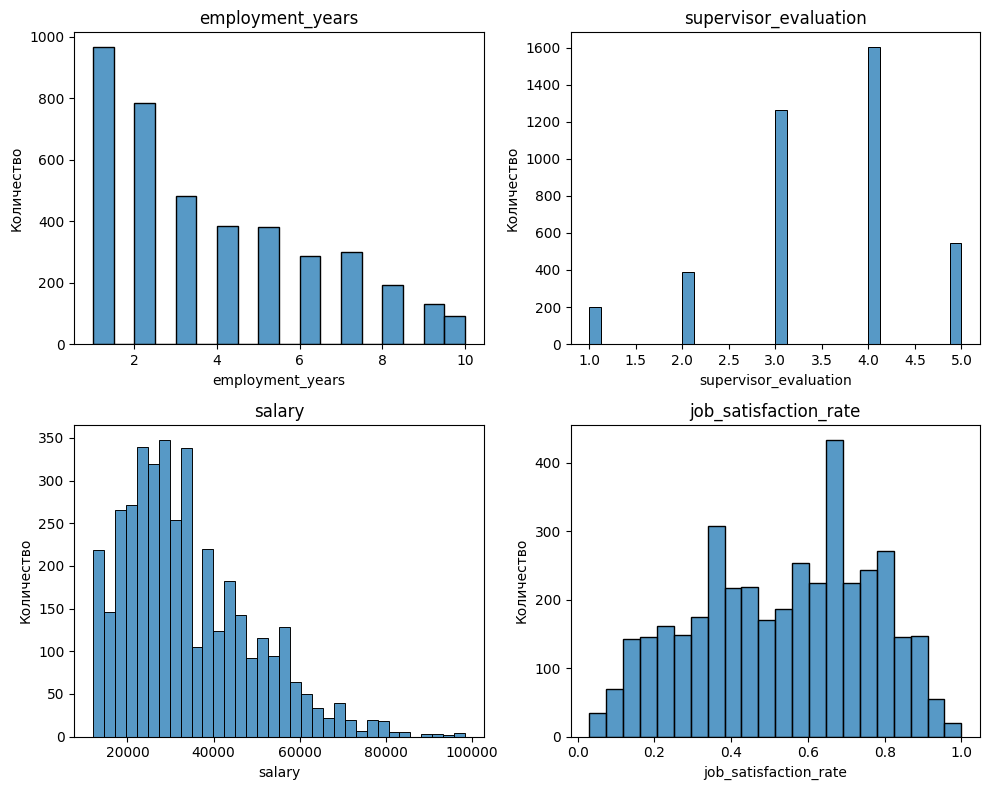

In [11]:
satisfaction_train = loading_data('train_job_satisfaction_rate.csv', 'satisfaction_train')

satisfaction_test


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
--------------------------------------------------------------------------------
Оценим к

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


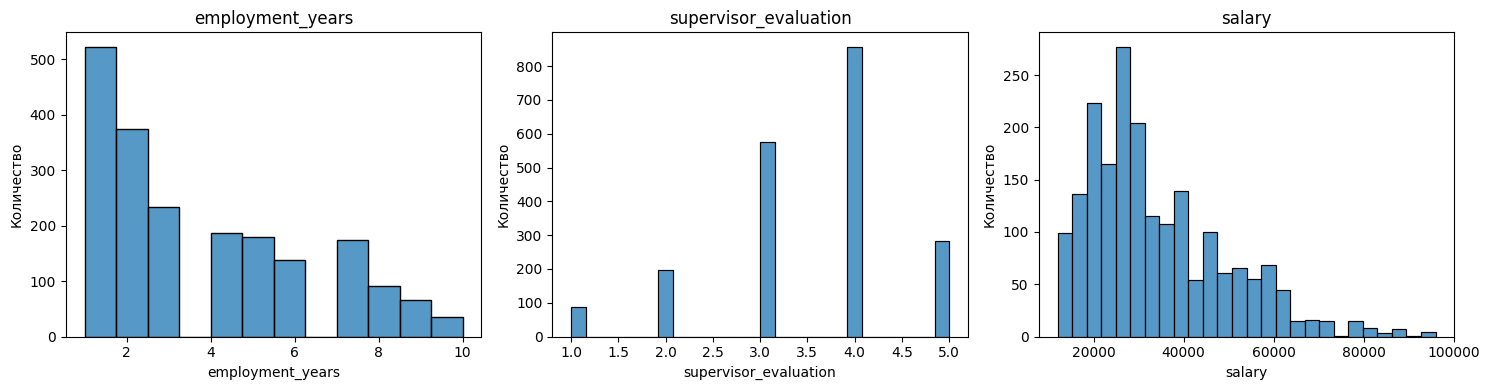

In [12]:
satisfaction_test = loading_data('test_features.csv', 'satisfaction_test')

In [13]:
satisfaction_target = loading_data('test_target_job_satisfaction_rate.csv', 
                                   'satisfaction_target', 
                                   figsize = (6,5), 
                                   graf=False )

satisfaction_target


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id                       0
job_satisfaction_rate    0
dtype: int64

quit_train


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None
-------------------------------------

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


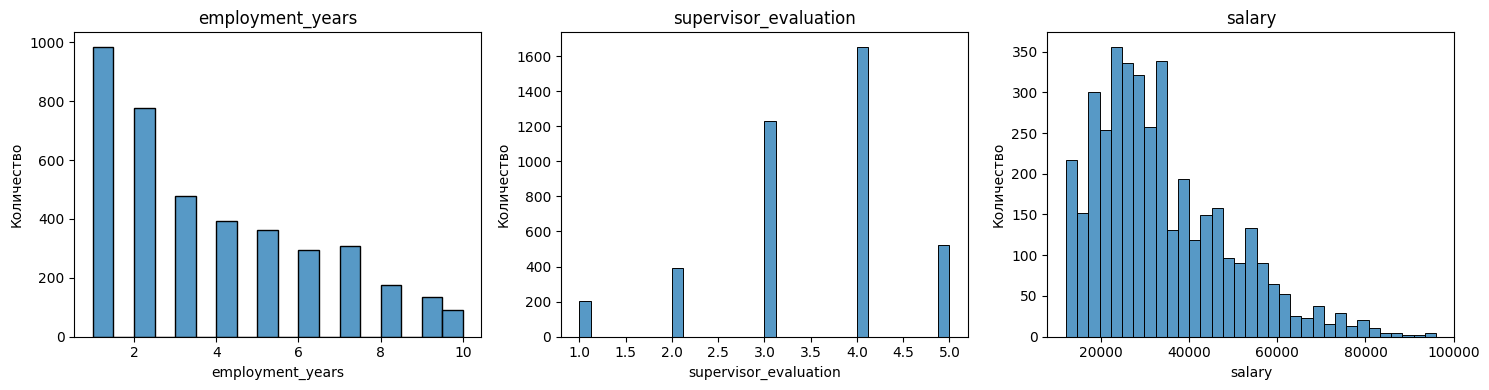

In [14]:
quit_train = loading_data('train_quit.csv', 'quit_train')

quit_test


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None
--------------------------------------------------------------------------------
Оценим к

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

--------------------------------------------------------------------------------
Визуализируем общие данные


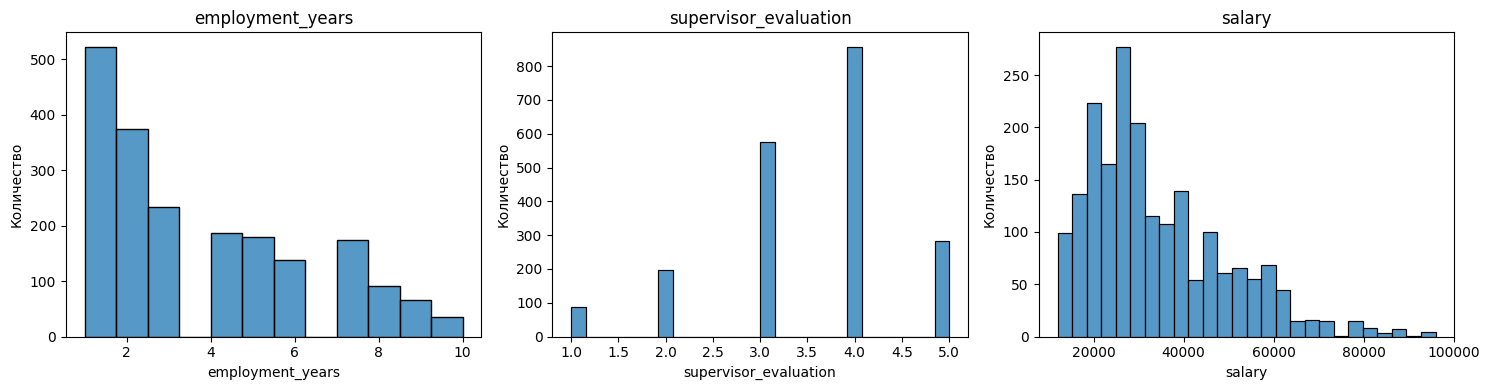

In [15]:
quit_test = loading_data('test_features.csv', 'quit_test')

In [16]:
quit_target = loading_data('test_target_quit.csv', 'quit_target', graf=False)

quit_target


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


--------------------------------------------------------------------------------
Общая информация о наборе данных, индекс, столбцы и тип данных, нулевые значения и использование памяти 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None
--------------------------------------------------------------------------------
Оценим количество пропущенных значений в каждом столбце



id      0
quit    0
dtype: int64

<div>

**Данные, для построения модели, которая сможет предсказать уровень удовлетворённости сотрудника**

*satisfaction_train*

*satisfaction_test*

*satisfaction_target*

- Есть единичные пропуски в тренировочной и тестовой датасетах, 
- тип данных указан верно. 
- Целевой признак указан как вероятность. Пороговые значения не определены. 


**Данные, для построения модели, которая будет предсказывать вероятность увольнения сотрудника**

*quit_train*

*quit_test*

*quit_target*

- Присутсвуют единичные пропуски в тестовом датасете, 
- тип данных указан верно. 
- Целевой признак категориальный. 

*Выбросы и аномалии на данном этапе не замечены.*

*Размер выборок репрезентативен и достаточек для анализа и построения модели.*

*Названия столбцов соответсвуют стандарту snake_case*
</div>

<a href='#content'>Вернуться к оглавлению</a> 

<a id='data_preprocessing'></a>

## Предобработка данных

In [17]:
satisfaction_train.query('dept.isna() or level.isna()')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
1209,631073,sales,NaN,medium,1,no,no,4,27600,0.66
1469,416327,sales,NaN,low,1,no,no,5,18000,0.73
1526,694746,NaN,junior,medium,5,no,no,4,21600,0.62
1630,814624,NaN,junior,medium,3,no,no,4,24000,0.88
1633,475114,NaN,junior,high,4,no,no,4,31200,0.63
1745,135043,sales,NaN,medium,1,no,no,3,26400,0.30
2522,998838,sales,NaN,medium,1,no,no,5,27600,0.71
2781,497243,NaN,junior,medium,1,no,no,3,26400,0.28
2975,168668,NaN,junior,low,3,no,no,4,18000,0.88
3866,641150,NaN,junior,low,3,no,yes,4,12000,0.54


Единичные пропуски, которые были замечены во время знакомства с данными, будут удалены в пайплайне.

### Явные и скрытые дубликаты

In [18]:
satisfaction_train = remove_duplicates(satisfaction_train, 'satisfaction_train')
satisfaction_test = remove_duplicates(satisfaction_test, 'satisfaction_test')
satisfaction_target = remove_duplicates(satisfaction_target, 'satisfaction_target')
quit_train = remove_duplicates(quit_train, 'quit_train')
quit_test = remove_duplicates(quit_test, 'quit_test')
quit_target = remove_duplicates(quit_target, 'quit_target')

Явные дубликаты в satisfaction_train отсутсвуют
Явные дубликаты в satisfaction_test отсутсвуют
Явные дубликаты в satisfaction_target отсутсвуют
Явные дубликаты в quit_train отсутсвуют
Явные дубликаты в quit_test отсутсвуют
Явные дубликаты в quit_target отсутсвуют


In [19]:
satisfaction_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [20]:
dataframes = {'satisfaction_train': satisfaction_train, 
              'satisfaction_test': satisfaction_test,
              'quit_train': quit_train,
              'quit_test': quit_test}

#dataframes = [satisfaction_train, satisfaction_test, quit_train, quit_test]
columns = ['dept', 'level', 'workload']
find_unique_values(dataframes, columns)

Уникальные значения в столбце dept датафрейма satisfaction_train:
['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]

Уникальные значения в столбце level датафрейма satisfaction_train:
['junior' 'middle' 'sinior' nan]

Уникальные значения в столбце workload датафрейма satisfaction_train:
['medium' 'high' 'low']

Уникальные значения в столбце dept датафрейма satisfaction_test:
['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']

Уникальные значения в столбце level датафрейма satisfaction_test:
['junior' 'middle' 'sinior' nan]

Уникальные значения в столбце workload датафрейма satisfaction_test:
['medium' 'low' 'high' ' ']

Уникальные значения в столбце dept датафрейма quit_train:
['sales' 'purchasing' 'marketing' 'technology' 'hr']

Уникальные значения в столбце level датафрейма quit_train:
['middle' 'junior' 'sinior']

Уникальные значения в столбце workload датафрейма quit_train:
['high' 'medium' 'low']

Уникальные значения в столбце dept датафрейма quit_test:
['marketin

Обнаружены пустые строки вместо значений в следующих датафреймах:

satisfaction_test['dept']

satisfaction_test['workload']

quit_test['dept']

quit_test['workload']

Пропуски будут заполнены  чаще всего встречающимся значением, в пайплайне, перед обучением модели.

Явные дубликаты отсутсвуют.

Тип данных соответсвует содержимому, датасеты готовы для дальнейшего анализа

<a href='#content'>Вернуться к оглавлению</a> 

 <a id='data_analysis'></a>

## Исследовательский анализ данных

In [21]:
satisfaction_train.describe()

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,544957.621000,3.718500,3.476500,33926.700000,0.533995
std,257883.104622,2.542513,1.008812,14900.703838,0.225327
min,100954.000000,1.000000,1.000000,12000.000000,0.030000
25%,322836.750000,2.000000,3.000000,22800.000000,0.360000
50%,534082.500000,3.000000,4.000000,30000.000000,0.560000
75%,771446.000000,6.000000,4.000000,43200.000000,0.710000
max,999521.000000,10.000000,5.000000,98400.000000,1.000000


In [22]:
quit_train.describe()

,id,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,552099.283750,3.701500,3.474750,33805.800000
std,260158.031387,2.541852,1.004049,15152.415163
min,100222.000000,1.000000,1.000000,12000.000000
25%,327785.750000,2.000000,3.000000,22800.000000
50%,546673.000000,3.000000,4.000000,30000.000000
75%,781497.750000,6.000000,4.000000,43200.000000
max,999915.000000,10.000000,5.000000,96000.000000


In [23]:
satisfaction_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [24]:
quit_test.describe()

,id,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000,2000.000000
mean,552765.213500,3.666500,3.526500,34066.800000
std,253851.326129,2.537222,0.996892,15398.436729
min,100298.000000,1.000000,1.000000,12000.000000
25%,339052.000000,1.000000,3.000000,22800.000000
50%,550793.000000,3.000000,4.000000,30000.000000
75%,765763.750000,6.000000,4.000000,43200.000000
max,999029.000000,10.000000,5.000000,96000.000000


In [25]:
satisfaction_target.describe()

,id,job_satisfaction_rate
count,2000.000000,2000.00000
mean,552765.213500,0.54878
std,253851.326129,0.22011
min,100298.000000,0.03000
25%,339052.000000,0.38000
50%,550793.000000,0.58000
75%,765763.750000,0.72000
max,999029.000000,1.00000


In [26]:
quit_target.describe()

,id
count,2000.000000
mean,552765.213500
std,253851.326129
min,100298.000000
25%,339052.000000
50%,550793.000000
75%,765763.750000
max,999029.000000


- Продолжительность работы в компании до 10 лет
- Оценка от руководителя по пятибальной шкале
- Заработная плата от 12 до 98 тыс. руб. Медиана 30 тыс. руб.
- Целевой признак, удовлетворенность работой, медианное значение 0.56

Тренировочная и тестовые выборки похожи. Нет видимого перекоса средних и медианных значений. 

Датасеты satisfaction_test/target и quit_test/target описывают одну группу сотрудников. Объедимим их в один датасет для исследовательского анализа

In [27]:
df=pd.merge(satisfaction_test, satisfaction_target, how='inner', on='id')
df = pd.merge(df, quit_target, how='inner', on='id')
print(df.shape)
df.head()

(2000, 11)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.72,no
2,467458,sales,middle,low,5,no,no,4,19200,0.64,no
3,418655,sales,middle,low,6,no,no,4,19200,0.60,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.75,no


Для визуализации данных будем использовать объединенный датасет с обоими целевыми признаками

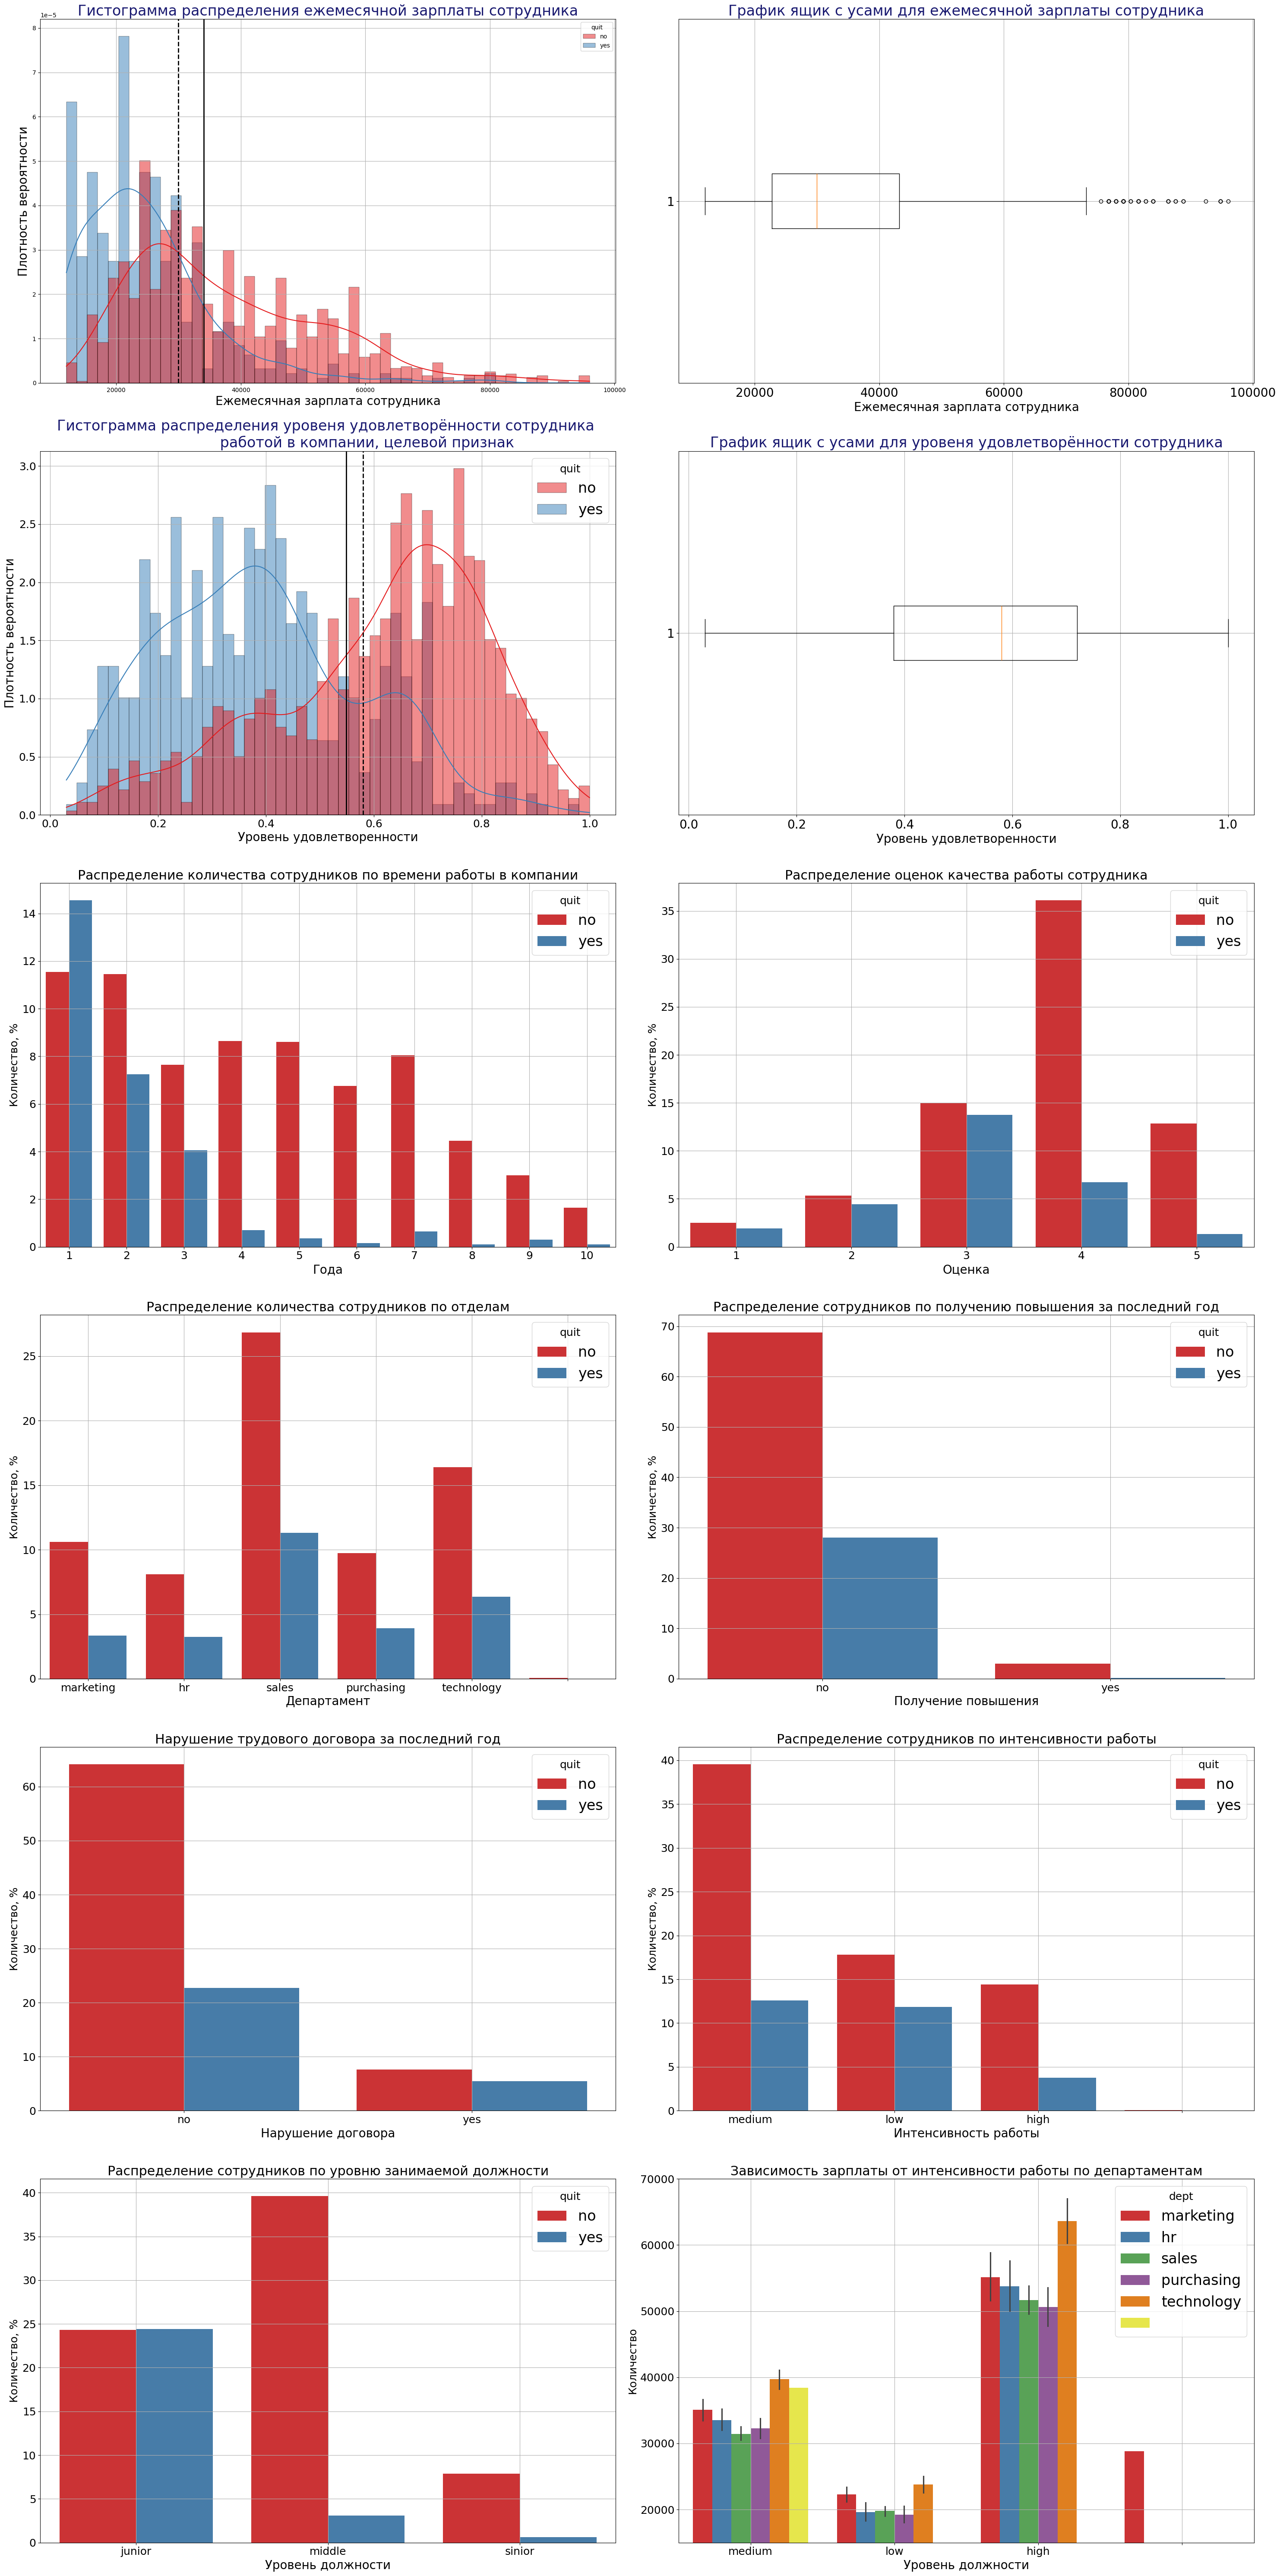

In [28]:
plt.figure(figsize=(30,60))
plt.subplot(6, 2, 1)
my_plot(data = df, 
        x_column = 'salary', 
        hue_column = 'quit',
        my_title = 'ежемесячной зарплаты сотрудника')
plt.xlabel('Ежемесячная зарплата сотрудника', fontsize = 20)

plt.subplot(6, 2, 2)
my_boxplot(data = df['salary'],
            my_title = 'ежемесячной зарплаты сотрудника')
plt.xlabel('Ежемесячная зарплата сотрудника', fontsize = 20)

plt.subplot(6, 2, 3)
my_plot(data = df, 
        x_column = 'job_satisfaction_rate', 
        hue_column = 'quit',
        my_title = 'уровеня удовлетворённости сотрудника \n \
                работой в компании, целевой признак')
plt.xlabel('Уровень удовлетворенности', fontsize = 20)

plt.subplot(6, 2, 4)
my_boxplot(data = df['job_satisfaction_rate'],
            my_title = 'уровеня удовлетворённости сотрудника') 
plt.xlabel('Уровень удовлетворенности', fontsize = 20)

plt.subplot(6,2,5)
sns.countplot(data=df, 
              x='employment_years', 
              hue= 'quit', 
              palette='Set1',
              stat = 'percent') 
plt.title('Распределение количества сотрудников по времени работы в компании')
plt.ylabel('Количество, %')
plt.xlabel('Года', fontsize = 20)
plt.grid(True)

plt.subplot(6,2,6)
sns.countplot(data=df, 
              x='supervisor_evaluation', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.title('Распределение оценок качества работы сотрудника')
plt.ylabel('Количество, %')
plt.xlabel('Оценка', fontsize = 20)
plt.grid(True)

plt.subplot(6, 2, 7)
sns.countplot(data=df, 
              x='dept', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.grid(True)
plt.title('Распределение количества сотрудников по отделам')
plt.xlabel('Департамент', fontsize = 20)
plt.ylabel('Количество, %')

plt.subplot(6, 2, 8)
sns.countplot(data=df, 
              x='last_year_promo', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.grid(True)
plt.title('Распределение сотрудников по получению повышения за последний год')
plt.xlabel('Получение повышения', fontsize = 20)
plt.ylabel('Количество, %')

plt.subplot(6, 2, 9)
sns.countplot(data=df, 
              x='last_year_violations', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.grid(True)
plt.title('Нарушение трудового договора за последний год')
plt.xlabel('Нарушение договора', fontsize = 20)
plt.ylabel('Количество, %')

plt.subplot(6, 2, 10)
sns.countplot(data=df, 
              x='workload', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.grid(True)
plt.title('Распределение сотрудников по интенсивности работы')
plt.xlabel('Интенсивность работы', fontsize = 20)
plt.ylabel('Количество, %')

plt.subplot(6, 2, 11)
sns.countplot(data=df, 
              x='level', 
              hue='quit', 
              palette='Set1', stat = 'percent')
plt.grid(True)
plt.title('Распределение сотрудников по уровню занимаемой должности')
plt.xlabel('Уровень должности', fontsize = 20)
plt.ylabel('Количество, %')


plt.subplot(6, 2, 12)
sns.barplot(df, y='salary', 
            x='workload', 
            hue='dept', 
            palette='Set1')
plt.grid(True)
plt.title('Зависимость зарплаты от интенсивности работы по департаментам')
plt.xlabel('Уровень должности', fontsize = 20)
plt.ylabel('Количество')
plt.ylim(15000, 70000)

plt.tight_layout()
plt.show()

In [29]:
describe_yes = df[df['quit'] == 'yes'].describe()
describe_yes

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,564.000000,564.000000,564.000000,564.000000,564.000000
mean,563164.792553,1.975177,3.042553,24955.319149,0.387713
std,251523.775926,1.552888,0.926211,10650.300744,0.185784
min,103221.000000,1.000000,1.000000,12000.000000,0.040000
25%,358969.500000,1.000000,3.000000,18000.000000,0.240000
50%,554657.000000,1.000000,3.000000,22800.000000,0.370000
75%,781640.250000,2.000000,4.000000,30000.000000,0.492500
max,999029.000000,10.000000,5.000000,80400.000000,0.970000


In [30]:
describe_no = df[df['quit'] == 'no'].describe()
describe_no 

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,1436.000000,1436.00000,1436.000000,1436.000000,1436.000000
mean,548680.699164,4.33078,3.716574,37645.403900,0.612040
std,254730.637881,2.54080,0.958965,15503.475156,0.199367
min,100298.000000,1.00000,1.000000,12000.000000,0.030000
25%,327477.750000,2.00000,3.000000,25200.000000,0.500000
50%,546372.000000,4.00000,4.000000,33600.000000,0.660000
75%,761578.500000,6.00000,4.000000,48000.000000,0.760000
max,998900.000000,10.00000,5.000000,96000.000000,1.000000


In [31]:
#На сколько удовлетворенность уволившегося сотрудника меньше оставшегося
(100 - (describe_yes.loc['50%', 'job_satisfaction_rate']/
        describe_no.loc['50%', 'job_satisfaction_rate'])*100).round(0)

44.0

In [32]:
#На сколько процентов отличается медианная зп уволившегося сотрудника от тех кто остался
(100 - (describe_yes.loc['50%', 'salary']
        /describe_no.loc['50%', 'salary'])*100).round(0)

32.0

In [33]:
quit_count = ((df[(df['quit'] == 'yes')& 
                (df['employment_years'] <= 3)]['id'].value_counts().sum()/
              df[df['quit'] == 'yes'].value_counts().sum())*100).round(0)
print('Доля уволившихся за первые 3 года работы от общего числа уволившихся', quit_count)


Доля уволившихся за первые 3 года работы от общего числа уволившихся 92.0


In [34]:
quit_count = ((df[(df['quit'] == 'yes')& 
                (df['employment_years'] == 1)]['id'].value_counts().sum()/
              df[df['quit'] == 'yes'].value_counts().sum())*100).round(0)
print('Доля уволившихся за первый год работы от общего числа уволившихся', quit_count)

Доля уволившихся за первый год работы от общего числа уволившихся 52.0


**Портрет уволившегося сотрудника**
1. Уволившийся сотрудник вероятнее всего работал в компании год. (52% сотрудников уходят в первый год работы. 92% от всех увольнений приходится на первые 3 года.)
2. Заработная плата уволившегося сотрудника на в среднем на 32% ниже медианного значения сотрудников, оставшихся в компании). Заработная плата около 23 тыс. руб. (В то время как у сотрудников, оставшихся в компании медианная зарплата 34 тыс. руб).
3. У работника была низкая удовлетворенность от работы в компании (около 0.4 и ниже), в то время как у оставшихся сотрудников 0.66. Что на 44% ниже.
4. Оценка качетсва работы скорее всего не выше 3 (70% уволившихся сотрудников имели оценку не выше 3)
5. Вероятнее всего сотрудник работал в отделе продаж
6. Не получал повышения за последний год
7. Вероятнее всего работа сотрудинка была с низкой или средней загрузкой. (Больше половины сотрудников с низкой загрузкой уходят)

<div>

***Выводы***
1. Гистограмма распределения ежемесячных зарплат сотрудника смещена влево. В первую очередь решение об увольнении принимают сотрудники с самой низкой зарплатой. Ящик с усами показывает аномальные значения справа группа сотрудников с высокой зарплатой.
2. Целевой признак - удовлетворенность работой в компании имеет два пика (в районе 0.4 и 0.7). В связи с этим медиана и среднее не отражают самую многочисленную группу. Интересно отметить, случаи нарушения трудового договора отмечены среди группы неудовлетовренных сотрудников.
3. Большая часть решений об увольнении сотрудники принимают в первые 3 года работы в компании. 
4. Гистограмма распределения оценок качества работы сотрудника показывает, что половина сотрудников с оценками до 3 как правило принимают решение об увольнении. 
5. Только 3 процента сотрудников получают повышение, продвижение в течении года.
6. Целевой признак (увольнение из компании) - минорный класс.
7. Половина сотрудников задействована в департаменте sales, technology.
8. Почти 50 процентов сотрудников имеют должность начального уровня.

</div>

<a href='#content'>Вернуться к оглавлению</a> 

<a id='Correlation_analysis'></a>

## Корреляционный анализ

In [35]:
corr = df[['dept', 
                                        'level', 
                                        'workload', 
                                        'employment_years', 
                                        'last_year_promo', 
                                        'last_year_violations',
                                        'supervisor_evaluation',
                                        'salary', 
                                        'job_satisfaction_rate',
                                         'quit' ]].phik_matrix(interval_cols=['employment_years',
                                                                            'supervisor_evaluation', 
                                                                            'salary', 
                                                                            'job_satisfaction_rate'])

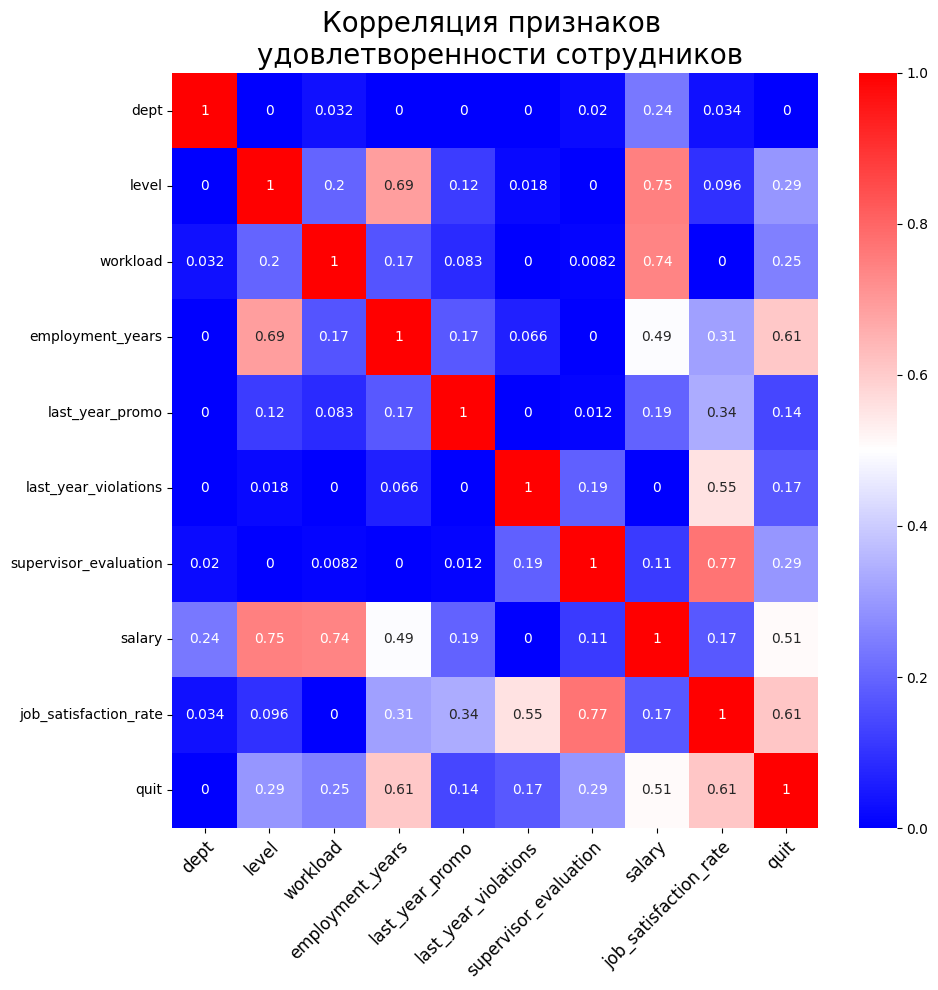

In [36]:
fig = plt.figure(figsize=(10,10))
plt.rcParams['font.size'] = 10

ax1 = sns.heatmap(corr, annot=True, cmap='bwr')
plt.setp(ax1.get_xticklabels(), 
         rotation=45, ha="right",
         rotation_mode="anchor",
         fontsize=12)
ax1.set_title("Корреляция признаков \n удовлетворенности сотрудников", fontsize=20)

plt.tight_layout()
plt.show()

Значений корреляции выше 0.9 не наблюдается в корреляционных матрицах, можно сделать вывод, что **мультиколлинеарность отсутствует**. 

Между входным признаком ***удовлетворенность сотрудника работой*** в компании установлены зависимости с (по степени снижения корреляционной зависимости):

- оценкой качества работы сотрудника, которую дал руководитель (сильная зависимость)
- отметкой о нарушении сотрудником трудового договора за последний год;
- длительностью работы в компании (в годах)
- наличием или отсутсвием повышения за последний год
- заработной платой.

Зависимость от уровня занимаемой должности сотрудника, департаментом, интенсивностью работы крайне слабая.

Между ***увольнением сотрудника*** установлены зависимости с:
- длительностью работы в компании (в годах)
- заработной платой
- уровнем занимаемой должности
- оценкой качества работы сотрудника
- отметкой о нарушении сотрудником трудового договора за последний год;
- наличием или отсутсвием повышения за последний год
- уровеня загруженности сотрудника

Зависимости от департамента не установлено.


In [37]:
X = add_constant(df[['employment_years',
                                     'supervisor_evaluation', 
                                     'salary', 
                                     'job_satisfaction_rate']])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

                 feature        VIF
0                  const  17.737435
1       employment_years   1.348034
2  supervisor_evaluation   2.071594
3                 salary   1.286756
4  job_satisfaction_rate   2.175737


Коэффициент инфляции дисперсии низкий (не превышает 5), коэффициенты корреляции ниже 0.9. Следовательно мультиколлинеарность между входными признаками окончательно исключаем.

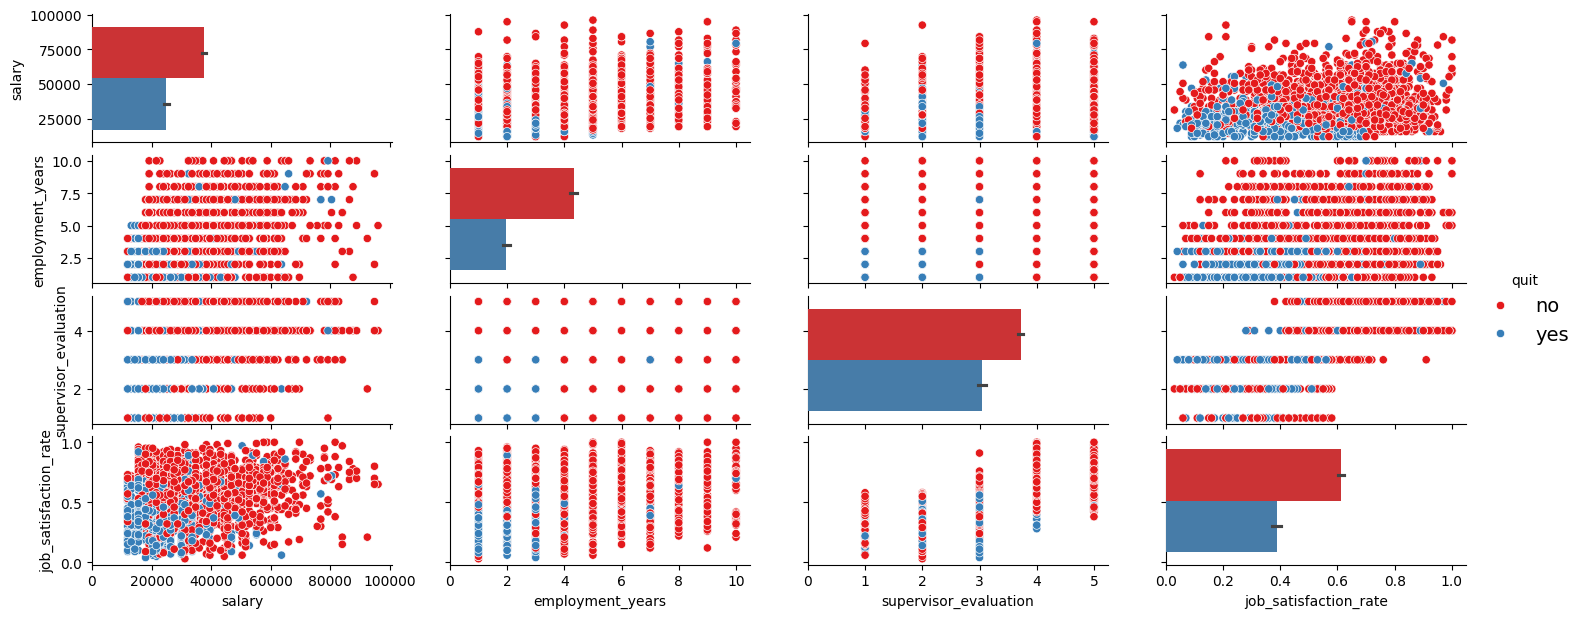

In [38]:
factor = [ 'salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate']
#factor_hue = ['last_year_promo' , 
#              'last_year_violations', 'quit']

plt.rcParams['font.size'] = 10
#for fac in factor_hue:
g = sns.PairGrid(data=df, 
                hue = 'quit', 
                x_vars = factor, 
                y_vars = factor, 
                palette = ("Set1")
)
g.fig.set_size_inches(15,6)

g.map_offdiag(sns.scatterplot)
g.map_diag(sns.barplot)
g.add_legend(fontsize=14)

plt.show()


На диаграмме рассеяния целевого признака (удовлетворенности сотрудинка работой в компании) от зарплаты линейной зависимости не установлено. Среди множества красных кружков единичные синие — свидетельство нестандартной комбинации признаков. Необычные значения целевого признака, которые мешают линейной модели учиться. И которые сложно предсказать. 

- Для обоих датасетов линейная зависимость не установлена. 

- Для решения задачи регрессии (предсказания уровня удовлетворенности сотрудника),  скорее всего подойдет дерево решений.

- На диаграммах рассеяния для входного признака уход из компании хорошо прослеживается граница между синими и красными кружками. Для решения задачи бинарной классификации скорее всего подойдет модель KNN, SVC или дерево решений.
На лицо дисбаланс классов в задаче бинарной классификации. 

<a href='#content'>Вернуться к оглавлению</a> 

<a id='ML'></a>

## Обучение моделей с помощью пайплайнов

### Модель для предсказания удовлетворенности сотрудников (модель регрессии)

<a id='regression'></a>

#### Подготовка датасетов

In [39]:
satisfaction_test.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [40]:
satisfaction_target.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [41]:
print('Размер тестового датасета для проверки',satisfaction_test.shape)
print('Целевой признак',satisfaction_target.shape)

Размер тестового датасета для проверки (2000, 9)
Целевой признак (2000, 2)


тестовая выборка и целевой признак к ней не отсортированы (столбец id указывает на это). При этом из статистических характеристик describe мы видели, что набор данных в id представлен тот же. Отсортируем по id можно через сортировку по id по каждому датасету, но надежнее сделать это через внутренее слияние и обратное разделение.

In [42]:
df_check = pd.merge(satisfaction_test, satisfaction_target, how='inner', on='id')
df_check.shape

(2000, 10)

In [43]:
df_check.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.79
1,686555,hr,junior,medium,1,no,no,4,30000,0.72
2,467458,sales,middle,low,5,no,no,4,19200,0.64
3,418655,sales,middle,low,6,no,no,4,19200,0.60
4,789145,hr,middle,medium,5,no,no,5,40800,0.75


In [44]:
X_test = df_check.drop(columns=['id',  
                                'job_satisfaction_rate'])
y_test = df_check['job_satisfaction_rate']
print('Размер тестового датасета для проверки',X_test.shape)
print('Целевой признак',y_test.shape)

Размер тестового датасета для проверки (2000, 8)
Целевой признак (2000,)


Проверим тренировочные данные на наличие дубликатов

In [45]:
print('Размер satisfaction_train до удаления дубликатов - ',
      satisfaction_train.shape)
satisfaction_train = satisfaction_train.drop_duplicates(
    subset=satisfaction_train.columns.difference(['id']), 
    keep='first')
print('Размер после удаления дубликатов -', satisfaction_train.shape)


Размер satisfaction_train до удаления дубликатов -  (4000, 10)
Размер после удаления дубликатов - (3755, 10)


Разделим тренировочный датасет на входные и целевые признаки

In [46]:
X_train = satisfaction_train.drop(columns=['id', 'job_satisfaction_rate'])
y_train = satisfaction_train['job_satisfaction_rate'] 

print('Размер датасета для обучения',X_train.shape)
print('Целевой признак',y_train.shape)

Размер датасета для обучения (3755, 8)
Целевой признак (3755,)


In [47]:
# Функция для расчета SMAPE в задачах регрессии
def smape_score(y_true, y_pred):
    n = len(y_true)
    numerator = np.abs(y_true - y_pred)*2
    denominator = (y_true + y_pred)

    return  100 / n * np.sum(numerator / denominator)

In [48]:
from sklearn.dummy import DummyRegressor
# Создаем модель, которая всегда предсказывает среднее значение
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train, y_train)

# Делаем предсказания
y_pred = dummy_regr.predict(X_test)

# Оцениваем модель
smape_dummy = smape_score(y_test, y_pred)
print("SMAPE на модели, которая всегда предсказывает средее:", smape_dummy)

SMAPE на модели, которая всегда предсказывает средее: 38.26225790202238


Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования. Признаки кодируем разными методами. 
Введём обозначения для типов исходных данных:

In [49]:
ohe_columns = [
    'last_year_promo',
    'last_year_violations',
    'workload',
    'level',
    'dept'
    
]
ord_columns = [
    'supervisor_evaluation',  
]
num_columns = ['salary', 'employment_years'] 

С помощью OneHotEncoder кодируем столбецы: 
- 'last_year_promo', 
- 'last_year_violations'
В данных есть пропуски, заполним их самым часто встречающимся значением с помощью SimpleImputer. 

с помощью OrdinalEncoder кодируем:
- 'supervisor_evaluation', 
Для каждого зададим порадок категоризации
Заполним пропуски самым часто встречающимся значением с помощью SimpleImputer. 


In [50]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 
# SimpleImputer + ORD + SimpleImputer

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['1', '2', '3', '4', '5'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Датасеты после предобработки

In [51]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
 
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
) 

Обучим тестовую модель линейной регрессии и посмотрим на метрику SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 


In [52]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',LinearRegression())
    ]
)
pipe_final.fit(X_train, y_train) 
y_pred = pipe_final.predict(X_test)

In [53]:
smape = smape_score(y_test, y_pred)
print(f'smape: {smape}')

smape: 26.599587062977005


Результат далек от идеала (должен быть < 15) Обучим новую модель, дерево решений и подберем для нее гиперпараметры

In [54]:
my_score = make_scorer(smape_score, greater_is_better=False) 
my_score 

make_scorer(smape_score, greater_is_better=False)

In [55]:
RANDOM_STATE = 42
"""
param_grid = {
    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'],
    'models' : [RandomForestRegressor(random_state=RANDOM_STATE)],
    'models__max_depth': range(2, 11),
    'models__min_samples_split': range(2, 11),
    'models__min_samples_leaf': range(1, 11),
    
}
"""
param_distributions = [
    
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
    },
     # словарь для модели RandomForestRegressor()
     {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]  
     }
]

search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv=5, 
    scoring=my_score,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit='false_positive_rate'
)


model_regres = search.fit(X_train, y_train)
best_model=model_regres.best_estimator_ 
best_score = -1*model_regres.best_score_ 
print('Лучшая модель и её параметры:\n\n', model_regres.best_estimator_) 
print('Метрика SMAPE:', -1*model_regres.best_score_)

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was rename

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations',
                                                   'workload', 'level',
                              

Модель показывает удовлетворительный результат.

In [56]:
result = pd.DataFrame(model_regres.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score')) 

,rank_test_score,param_models,mean_test_score,params
8,1,"DecisionTreeRegressor(max_depth=13, min_sample...",-15.504733,"{'preprocessor__num': MinMaxScaler(), 'models_..."
7,2,"DecisionTreeRegressor(max_depth=13, min_sample...",-15.756715,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,3,RandomForestRegressor(random_state=42),-15.834272,"{'preprocessor__num': RobustScaler(), 'models_..."
4,4,"DecisionTreeRegressor(max_depth=13, min_sample...",-15.966429,"{'preprocessor__num': MinMaxScaler(), 'models_..."
6,5,RandomForestRegressor(random_state=42),-16.643817,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,6,"DecisionTreeRegressor(max_depth=13, min_sample...",-16.719984,"{'preprocessor__num': RobustScaler(), 'models_..."
5,7,RandomForestRegressor(random_state=42),-16.723046,"{'preprocessor__num': StandardScaler(), 'model..."
1,8,"DecisionTreeRegressor(max_depth=13, min_sample...",-22.705524,"{'preprocessor__num': RobustScaler(), 'models_..."
0,9,RandomForestRegressor(random_state=42),-23.776384,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,10,"DecisionTreeRegressor(max_depth=13, min_sample...",-23.965105,"{'preprocessor__num': MinMaxScaler(), 'models_..."


In [57]:
result.iloc[8]['param_models']

DecisionTreeRegressor(max_depth=13, min_samples_leaf=7, min_samples_split=10,
                      random_state=42)

In [58]:
y_pred = best_model.predict(X_test)
print('SMAPE на тестовой выборке:', (smape_score(np.array(y_test), np.array(y_pred))).round(3))

SMAPE на тестовой выборке: 14.121


In [59]:
print('Точность модели:', best_score.round(2))
print('Смещение модели:', (best_score - smape_score(np.array(y_test), np.array(y_pred))).round(3), '%')


Точность модели: 15.5
Смещение модели: 1.384 %


Лучшей моделью оказалась DecisionTreeRegressor(max_depth=13, min_samples_leaf=7, min_samples_split=10). Числовые данные были отмасшабированы с помощью MinMaxScaler()
Модель показала должную точность по метрике SMAPE. На тестовой выборке smape - 0.142

В процессе поиска лучшей модели были обучены модели линейной регресии и RandomForestRegressor. Модели SVC и KNN не рассматривались, т.к. плохо работают на данных, где привалируют категориальные входные признаки

<a href='#content'>Вернуться к оглавлению</a> 

<a id='classification'></a>

### Модель для предсказания увольнения сотрудника (модель классификации)

### Добавление нового входного признака

При корреляционном анализе мы обнаружили, что удовлетворенность сотрудника зависит от увольнения сотрудника. Поэтому спрогнозируем уровень удовлетворенности сотрудников и добавим этот входной признак к нашим данным. 

In [60]:
quit_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [61]:
print('Размер quit_train до удаления дубликатов - ',
      quit_train.shape)
satisfaction_train = quit_train.drop_duplicates(
    subset=quit_train.columns.difference(['id']), 
    keep='first')
print('Размер после удаления дубликатов -', quit_train.shape)


Размер quit_train до удаления дубликатов -  (4000, 10)
Размер после удаления дубликатов - (4000, 10)


In [62]:
quit_train_satisfaction = (best_model.predict(quit_train)).round(2)
quit_train['job_satisfaction_rate'] = pd.Series(quit_train_satisfaction, name='job_satisfaction_rate')
quit_train.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.64
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.83
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.35
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.36
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.80


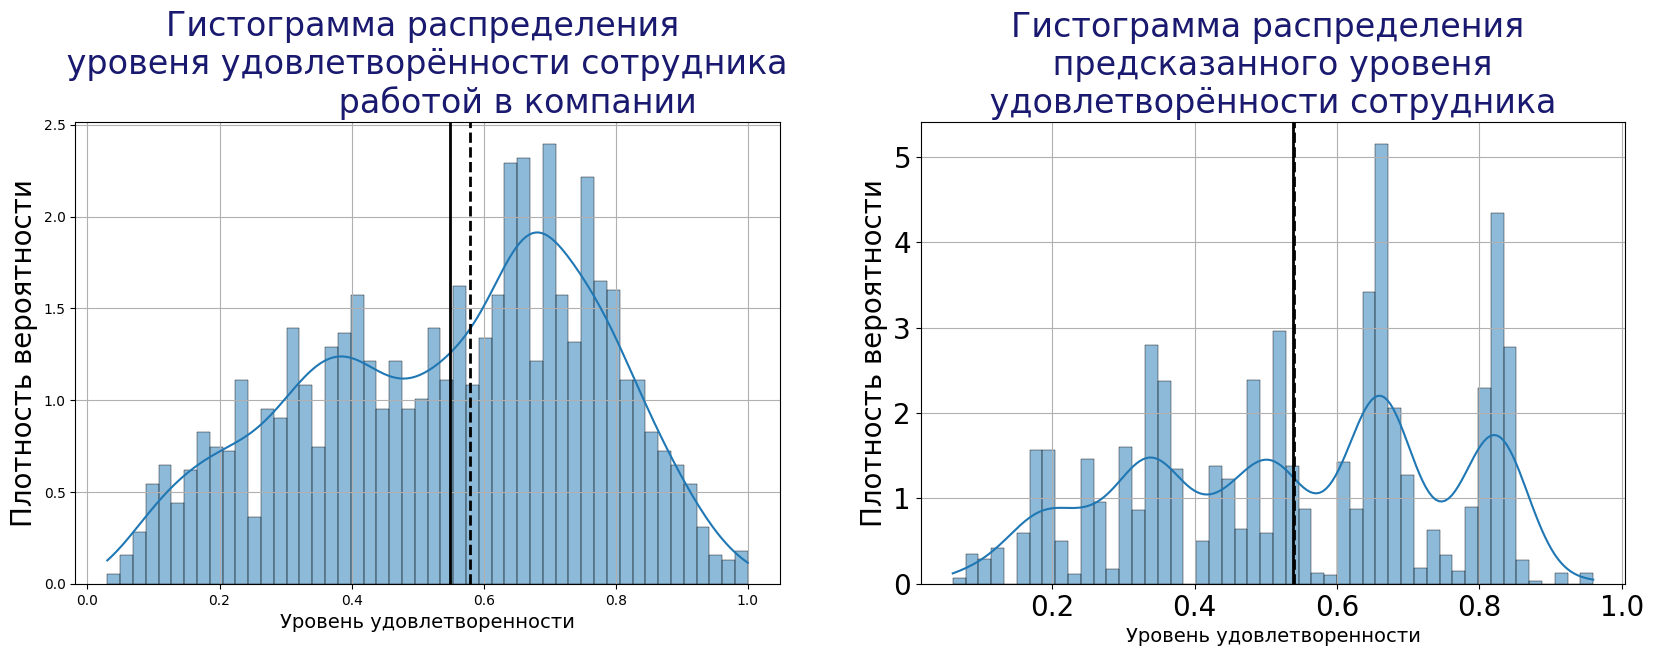

In [63]:
plt.figure(figsize=(20,6))
plt.subplot(1, 2, 1)
my_plot(data = df, 
        x_column = 'job_satisfaction_rate', 
        hue_column = None,
        my_title = '\n уровеня удовлетворённости сотрудника \n \
                работой в компании')
plt.xlabel('Уровень удовлетворенности', fontsize = 14)
plt.subplot(1, 2, 2)
my_plot(data = quit_train, 
        x_column = 'job_satisfaction_rate', 
        hue_column = None,
        my_title = '\n предсказанного уровеня \n удовлетворённости сотрудника ')
plt.xlabel('Уровень удовлетворенности', fontsize = 14)
plt.show()

Вид гистограммы распределения уровня удовлетворенности предсказанный и фактически расчитанный согласуются по форме.

Разделим тренировочный датасет на входные и целевые признаки.
Отметим, что согласно корреляционной матрице уход из компании не зависит от департамента сотрудника. Данный признак не будем включать в список входных признаков.

In [64]:
X_train = quit_train.drop(columns=['id', 'quit', 'dept', 'last_year_promo'])
y_train = quit_train['quit'] 

print('Размер датасета для обучения',X_train.shape)
print('Целевой признак',y_train.shape)

Размер датасета для обучения (4000, 7)
Целевой признак (4000,)


In [65]:
X_train.head()

,level,workload,employment_years,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,middle,high,2,no,4,54000,0.64
1,junior,medium,2,no,4,27600,0.83
2,middle,medium,5,no,1,37200,0.35
3,junior,medium,2,yes,3,24000,0.36
4,junior,medium,2,no,5,25200,0.80


In [66]:
X_test = df.drop(columns=['id', 'quit', 'dept', 'last_year_promo'])
y_test = df['quit']
print('Размер тестового датасета для проверки',X_test.shape)
print('Целевой признак',y_test.shape)

Размер тестового датасета для проверки (2000, 7)
Целевой признак (2000,)


Ранее в целевом признаке был обнаружен дисбаланс классов.

<function matplotlib.pyplot.show(close=None, block=None)>

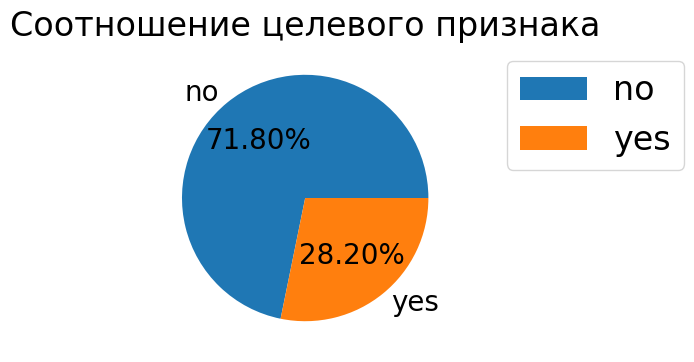

In [67]:
plt.figure(figsize=(4, 4))
my_pie(y_train, 'целевого признака')
plt.show

Избавимся от дисбаланса с помощью оверсемплинга

In [68]:
sampler = RandomOverSampler(random_state=RANDOM_STATE)
X_train_sampled, y_train_sampled = sampler.fit_resample(X_train, y_train)
print(f'Тренировочные данные до сэмплирования:\n \
      {y_train.value_counts()}')
print(f'\nТренировочные данные после сэмплирования:\n \
      {y_train_sampled.value_counts(),}')

Тренировочные данные до сэмплирования:
       quit
no     2872
yes    1128
Name: count, dtype: int64

Тренировочные данные после сэмплирования:
       (quit
no     2872
yes    2872
Name: count, dtype: int64,)


Закодируем целевой признак:
- Значение целевого признака no - 0
- Значение yes - 1

In [69]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_sampled)
y_test = label_encoder.transform(y_test)

y_train = pd.Series(y_train, name = 'quit')
y_test = pd.Series(y_test, name = 'quit')
y_train.head()

0    0
1    0
2    0
3    1
4    0
Name: quit, dtype: int64

In [70]:
y_train.shape

(5744,)

Сначала обозначим, какие данные требуют масштабирования, а какие — кодирования. Признаки кодируем разными методами. 
Введём обозначения для типов исходных данных:

In [71]:
ohe_columns = [
    'last_year_violations',
    'workload',
    'level',  
]
ord_columns = [
    'supervisor_evaluation',  
]
num_columns = ['salary', 'employment_years'] 

С помощью OneHotEncoder кодируем столбецы: 
- 'last_year_violations'
- 'workload',
- 'level',

В данных есть пропуски, заполним их самым часто встречающимся значением с помощью SimpleImputer. 

с помощью OrdinalEncoder кодируем:
- 'supervisor_evaluation', 
Для каждого зададим порадок категоризации
Заполним пропуски самым часто встречающимся значением с помощью SimpleImputer. 

'job_satisfaction_rate' - не требует масштабирования.


In [72]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 
# SimpleImputer + ORD + SimpleImputer

ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['1', '2', '3', '4', '5'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Датасеты после предобработки

In [73]:
X_train_p = pd.DataFrame(
    data_preprocessor.fit_transform(X_train_sampled),
    columns=data_preprocessor.get_feature_names_out()
)
 
X_test_p = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
) 

Лучшую модель будем искать среди моделей 
- DecisionTreeClassifier()
- LogisticRegression()
- SVC()
- KNeighborsClassifier()


In [74]:
param_distributions = [
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough'], 
        'models__kernel': ['rbf', 'sigmoid', 'linear', 'poly' ],
        'models__C': [0.01,0.1,1,2,5],
        'models__gamma': [0.01,0.1,1,2,5]
    },
    # словарь для модели LogisticRegression(penalty = 'l2')
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'] 
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='saga')],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough'], 
        'models__penalty': ['l1', 'elasticnet']
    },
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'models__min_samples_leaf': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(),'passthrough']  
    }
    
]

In [75]:


pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',LogisticRegression(random_state=RANDOM_STATE))
    ]
)

search_classific_model = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    cv = StratifiedKFold(n_splits=2), 
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    
)
model_classification = search_classific_model.fit(X_train_sampled, y_train)
best_classific_model=model_classification.best_estimator_ 
best_classific_score = model_classification.best_score_ 
print('Лучшая модель и её параметры:\n\n', model_classification.best_estimator_) 
print('Метрика ROC-AUC:', model_classification.best_score_)

/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/envs/practicum/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was rename

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['last_year_violations',
                                                   'workload', 'level']),
                                                 ('ord',
                                         

Модель показывает отличный результат по метрике ROC_AUC. Целых 95.5% Посмотрим топ10 моделей, их гиперпараметры и значение метрики

In [76]:
result = pd.DataFrame(model_classification.cv_results_)
display(result[
    ['rank_test_score', 'param_models', 'mean_test_score','params']
].sort_values('rank_test_score'))

,rank_test_score,param_models,mean_test_score,params
0,1,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.955647,"{'preprocessor__num': MinMaxScaler(), 'models_..."
4,2,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.953739,"{'preprocessor__num': MinMaxScaler(), 'models_..."
3,3,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.953017,"{'preprocessor__num': RobustScaler(), 'models_..."
7,4,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.952433,"{'preprocessor__num': MinMaxScaler(), 'models_..."
9,5,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.952114,"{'preprocessor__num': MinMaxScaler(), 'models_..."
2,6,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.951712,"{'preprocessor__num': MinMaxScaler(), 'models_..."
5,7,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.949975,"{'preprocessor__num': StandardScaler(), 'model..."
8,8,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.945539,"{'preprocessor__num': MinMaxScaler(), 'models_..."
1,9,"DecisionTreeClassifier(max_depth=11, min_sampl...",0.866153,"{'preprocessor__num': 'passthrough', 'models__..."
6,10,"LogisticRegression(random_state=42, solver='sa...",NaN,"{'preprocessor__num': MinMaxScaler(), 'models_..."


Лучше всего справилась модель **DecisionTreeClassifier** и это ожидаемо. Т.к. входыне признаки в первую очередь состоят из классификационных признаков. На таком наборе данных модели *KNN и SCV* плохо работают. 

Во время исследовательского анализа данных не было обнаружено линейных зависимостей. 

Логистическая регрессия предполагает линейную связь между признаками и целевой переменной. В наших данных присутствуют нелинейные зависимости, поэтому модель *LogisticRegression* не справилась с их отображением.

Проверим результат лучшей модели на тестовых данных

In [77]:
y_test_pred = best_classific_model.predict_proba(X_test)[:, 1]
print(f'Метрика roc_auc на тестовой выборке: {roc_auc_score(y_test, y_test_pred).round(2)}')

Метрика roc_auc на тестовой выборке: 0.91


<div class="alert alert-success">
<b>КОММЕНТАРИЙ V2</b> 	

Здесь сейча всё хорошо. Расчёт ROC-AUC выполнен верно, через предсказанную вероятности класса 1. Здесь большой процент ошибок я часто вижу (коллеги делают расчет передавая вторым параметром не вероятность а признаки валидационной выборки). 
    
Площадь под ROC-кривой (Area Under Curve – площадь под кривой, Receiver Operating Characteristic – рабочая характеристика приёмника ... пришло из области радиоэлектроники) – это метрика оценки для задач бинарной классификации. ROC-кривая показывает зависимость между долей верно классифицированных объектов положительного класса и долей ложноположительных объектов. Ну и сама площадь под ROC-кривой является мерой качества классификатора: чем выше значение AUC (Area Under Curve), тем лучше качество классификации конкретной модели. Наш глаз и мозг устроены так, что мы очень хорошо видим геометрическую разницу (в данном случае площадей).
</div>

In [78]:
print('Точность модели:', best_classific_score.round(2))
print('Разброс модели:', ((best_classific_score - roc_auc_score(y_test, y_test_pred)).round(4))*100, '%')

Точность модели: 0.96
Разброс модели: 4.58 %


Лучшая модель DecisionTreeClassifier
 
Метрика оценки качества — ROC-AUC соответсвует критериям на тестовой выборке.

Посмотрим как разные признаки повлияли на решение модели

In [79]:
model = DecisionTreeClassifier(max_depth=11, min_samples_leaf=5,
                                        min_samples_split=12,
                                        random_state=42)
model.fit(X_train_p,y_train)
def f(x):
    return model.predict_proba(x)[:, 1]


med = X_train_p.median().values.reshape((1, X_train_p.shape[1]))

explainer = shap.Explainer(f, med)

shap_values = explainer(X_test_p.iloc[0:1000, :])

<div class="alert alert-success">
<b>ОТЛИЧНО! 👍</b>

О, shap используешь. СУПЕР. "В жизни" редко его встречаю. Обычно feature_importances все оперируют. МОЛОДЕЦ!

---
Графики SHAP предоставляют визуальное объяснение влияния каждого признака на модель. Вот некоторые ключевые типы графиков SHAP и их интерпретация:

1. **Summary Plot (Общий график):**

* Главная цель этого графика - показать вклад каждого признака в прогнозы модели.
* График показывает каждый признак на оси X, где точка на графике представляет вклад этого признака в прогноз.
* Положительные значения указывают, что большее значение этого признака повышает прогноз, отрицательные - понижает.

2. **Force Plot (График силы влияния):**

* Позволяет увидеть, как каждый признак влияет на конкретный прогноз.
* Визуализирует SHAP-значения для каждого признака для определенной точки данных и как они влияют на прогноз.

3. **Dependence Plot (График зависимости):**

* Показывает взаимосвязь между значением конкретного признака и предсказанием модели.
* Позволяет увидеть, как меняется предсказание при изменении значения одного признака, при условии, что остальные признаки фиксированы.

4. **Waterfall Plot (График водопада):**

*Представляет изменения от базового прогноза до конечного прогноза для каждого наблюдения.

* Показывает влияние каждого признака на изменение прогноза относительно базового значения.

5. **Interaction Value Plot (График взаимодействия):**

* Позволяет увидеть, как взаимодействие между двумя признаками влияет на прогноз.
* Он показывает, как изменения значений двух признаков влияют на SHAP-значения.

Когда рассматриваешь графики SHAP, обрати внимание на направление и величину влияния каждого признака на прогноз. Положительные значения обычно повышают прогноз, отрицательные - понижают. Важно также анализировать взаимодействия между признаками и их зависимости от целевой переменной.
</div>

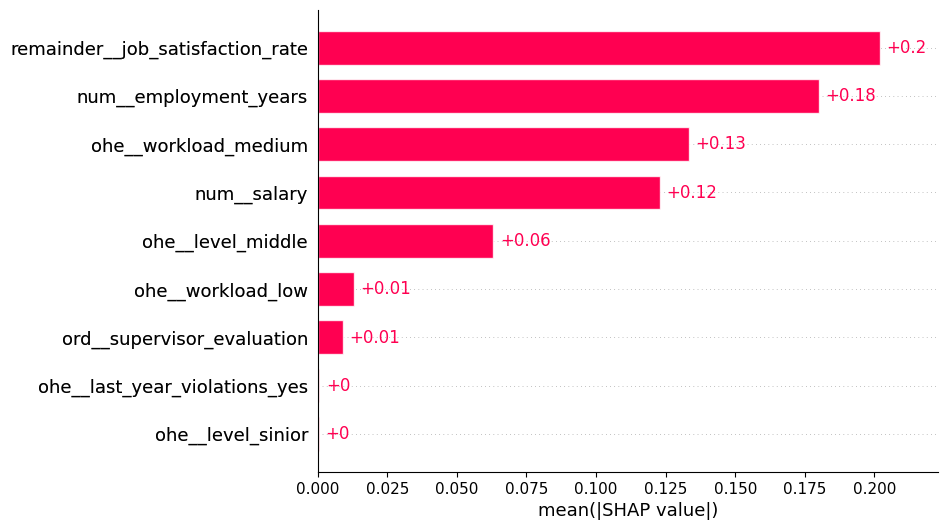

In [80]:
shap.plots.bar(shap_values, max_display=15) 

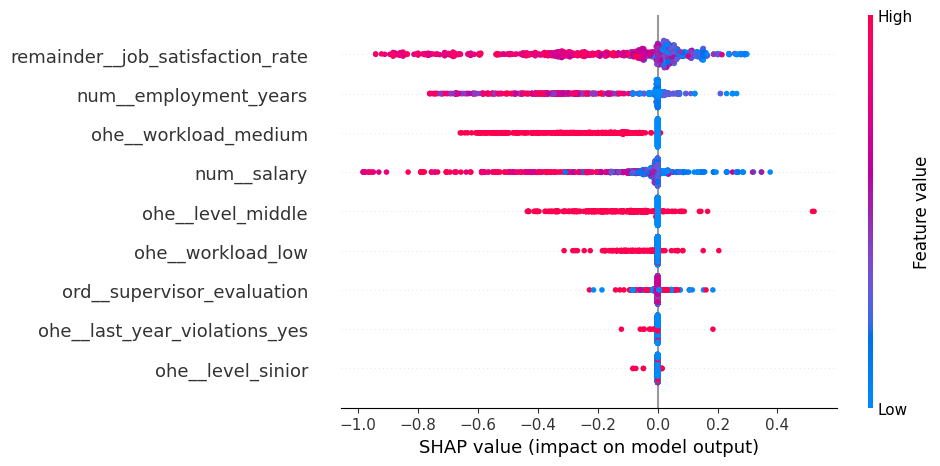

In [81]:
shap.plots.beeswarm(shap_values, max_display=19)

На графиках видно, что все признаки (до их кодирования) вносят свой вклад в модель. Признаки 'dept' и 'last_year_promo' были исключены, т.к. имели низкую корреляцию с целевым признаком и приводили к переобучению модели. 
Входные признаки расположены в порядке убывания их значимости.

Основное влияние на принятие решения об увольнении по мнению модели сотрудник принимает:
- из-за низкой удовлетворенности работой
- в первые годы работы в компании
- низкой зарплаты

В тоже время для сохранения сотдудников в компании помимо высоких показателей зараплаты влияет уровень занимаемой должности. 

Таким образом, своевременное повышение сотрудника до среднего уровня увеличивает шансы, что он останется в компании

<a href='#content'>Вернуться к оглавлению</a> 

## Выводы

<a id='conclusions'></a></br>

**Проблема:** Высокий уровень текучести кадров в компании приводит к потере квалифицированных специалистов и увеличению затрат на поиск и обучение новых сотрудников.

**Для решения проблемы:** разработаны две модели машинного обучения, первая позволяет предсказывать степень удовлетворенности сотрудника, вторая предсказывает увольнения сотрудника на ранних этапах.

**В ходе предобработки данных** были замечены пропуски в данных, была произведена проверка на дубликаты.
Тренировочная и тестовые выборки похожи. Нет видимого перекоса средних и медианных значений. 
Датасеты satisfaction_test/target и quit_test/target описывают одну группу сотрудников. Поэтому для визуализации данных и корреляционного анализа данные объединены в один дата сет.

**На этапе исследовательского анализа** данных установлено:
1. Гистограмма распределения ежемесячных зарплат сотрудника смещена в сторону низких зарплат. В первую очередь решение об увольнении принимают сотрудники с самой низкой зарплатой. Ящик с усами показывает аномальные значения справа -группа сотрудников с высокой зарплатой.
2. Целевой признак - удовлетворенность работой в компании имеет два пика (в районе 0.4 и 0.7). В связи с этим медиана и среднее не отражают самую многочисленную группу. 
3. Большая часть решений об увольнении сотрудники принимают в первые 3 года работы в компании. 
4. Гистограмма распределения оценок качества работы сотрудника показывает, что половина сотрудников с оценками до 3 как правило принимают решение об увольнении. 
5. Только 3 процента сотрудников получают повышение, продвижение в течение года.
6. Целевой признак (увольнение из компании) - минорный класс.
7. Половина сотрудников задействована в департаменте sales, technology.
8. Почти 50 процентов сотрудников имеют должность начального уровня.

Составлен **портрет уволившегося сотрудника**
1. Уволившийся сотрудник вероятнее всего работал в компании год. (52% сотрудников уходят в первый год работы. 92% от всех увольнений приходится на первые 3 года.)
2. Заработная плата уволившегося сотрудника на в среднем на 32% ниже медианного значения сотрудников, оставшихся в компании). Заработная плата около 23 тыс. руб. (В то время как у сотрудников, оставшихся в компании медианная зарплата 34 тыс. руб).
3. У работника была низкая удовлетворенность от работы в компании (около 0.4 и ниже), в то время как у оставшихся сотрудников 0.66. Что на 44% ниже.
4. Оценка качетсва работы скорее всего не выше 3 (70% уволившихся сотрудников имели оценку не выше 3)
5. Вероятнее всего сотрудник работал в отделе продаж
6. Не получал повышения за последний год
7. Вероятнее всего работа сотрудинка была с низкой или средней загрузкой. (Больше половины сотрудников с низкой загрузкой уходят)

**В ходе корреляционного анализа** была сделана проверка на мультиколлинеарность. 
Коэффициент инфляции дисперсии низкий (не превышает 5), коэффициенты корреляции ниже 0.9.

Между входным признаком *удовлетворенность сотрудника работой* в компании установлены зависимости с:

- оценкой качества работы сотрудника, которую дал руководитель (сильная зависимость)
- отметкой о нарушении сотрудником трудового договора за последний год;
- длительностью работы в компании (в годах)
- наличием или отсутствием повышения за последний год
- заработной платой.

Зависимость от уровня занимаемой должности сотрудника, департаментом, интенсивностью работы крайне слабая.

Между *увольнением сотрудника* установлены зависимости с:
- длительностью работы в компании (в годах)
- заработной платой
- уровнем занимаемой должности
- оценкой качества работы сотрудника
- отметкой о нарушении сотрудником трудового договора за последний год;
- наличием или отсутствием повышения за последний год
- уровня загруженности сотрудника
Зависимости от департамента не установлено.
Линейная зависимость между входными и целевыми признаками не установлена.

Для решения **задачи регрессии (предсказания уровня удовлетворенности сотрудника)**
Входные признак: 'last_year_promo', 'last_year_violations' закодированы с помощью OneHotEncoder 
- 'supervisor_evaluation' закодирован с помощью OrdinalEncoder
Пропуски в данных, заполнили их самым часто встречающимся значением с помощью SimpleImputer. 

Для оценки качества модели используется метрика *SMAPE*
(Symmetric Mean Absolute Percentage Error) – симметричная средняя абсолютная процентная ошибка
– это метрика, которая используется для оценки точности прогнозов в задачах регрессии. Она показывает среднюю абсолютную процентную ошибку между фактическими и прогнозными значениями. В отличие от других метрик, таких как MAPE (Mean Absolute Percentage Error), SMAPE одинаково штрафует как завышенные, так и заниженные прогнозы. Это особенно важно, когда ошибки в обе стороны имеют одинаковую значимость. SMAPE выражается в процентах, что делает ее удобной для сравнения моделей, работающих с данными разных масштабов. Менее чувствительна к выбросам по сравнению с некоторыми другими метриками.

Первая обученная модель – Линейной регрессии показала слабый результат, ошибка 21%
Модели SVC и KNN не рассматривались, т.к. плохо работают на данных, где превалируют категориальные входные признаки. С помощью RandomizedSearchCV была подобрана лучшая модель и геперпараметры для нее. Ей оказалась оказалась **DecisionTreeRegressor(max_depth=13, min_samples_leaf=7, min_samples_split=10)**. Числовые данные были отмасшабированы с помощью MinMaxScaler()
**Ошибка модели 14.82%, на тестовой выборке 14.23%**

С помощью полученной модели был сделан прогноз удовлетворенности работой для выборки, которая использовалась для обучения **модели бинарной классификации**(целевой признак уход из компании)
В целевом признаке присутствовал дисбаланс, с помощью оверсемплинга он был устранен. 
В качестве входных признаков использовались только значимые, признаки, которые не показали значимой корреляции были исключены из модели, т.к. приводили к ее переобучению. (Это признаки 'dept' и 'last_year_promo') 
Для поиска лучшей модели были обучены:
- DecisionTreeClassifier()
- LogisticRegression()
- SVC()
- KNeighborsClassifier()

Лучше всего справилась модель **DecisionTreeClassifier (max_depth=11, min_samples_leaf=5,min_samples_split=12, random_state=42) метрика ROC_AUC целых 95.5%**  и это ожидаемо. Т.к. входные признаки в первую очередь состоят из классификационных признаков. На таком наборе данных модели *KNN и SCV* плохо работают. 
Логистическая регрессия предполагает линейную связь между признаками и целевой переменной. В наших данных присутствуют нелинейные зависимости, поэтому модель *LogisticRegression* не справилась с их отображением. 
**Метрика roc_auc на тестовой выборке: 91,15.** Модель показала высокую точность прогнозирования.
Интерпретация модели проводилась с использованием инструментов визуализации shap.
*Идентифицированы ключевые факторы, влияющие на решение сотрудника об увольнении (низкая зарплата, отсутствие карьерного роста, низкая удовлетворенность работой).*

**Рекомендации:** 

1.	Внедрить систему мониторинга удовлетворенности сотрудников, с исользованием разработанной модели
2. Внедрить конкретные меры по повышению удовлетворенности сотрудников, такие как: 
-	Программы обучения и развития
-	Улучшение условий труда
-	Повышение прозрачности системы оплаты труда
-	Создание системы обратной связи
-	Организация мероприятий для сплочения коллектива







